# Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Preprocessing

## Dataset Paths

In [12]:
DATA_DIR = "F:\CV project\Traffic project"
TRAIN_DIR = "F:\CV project\Traffic project\Train"
TEST_DIR = "F:\CV project\Traffic project\Test"

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [ ]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

## Visualizing the Dataset

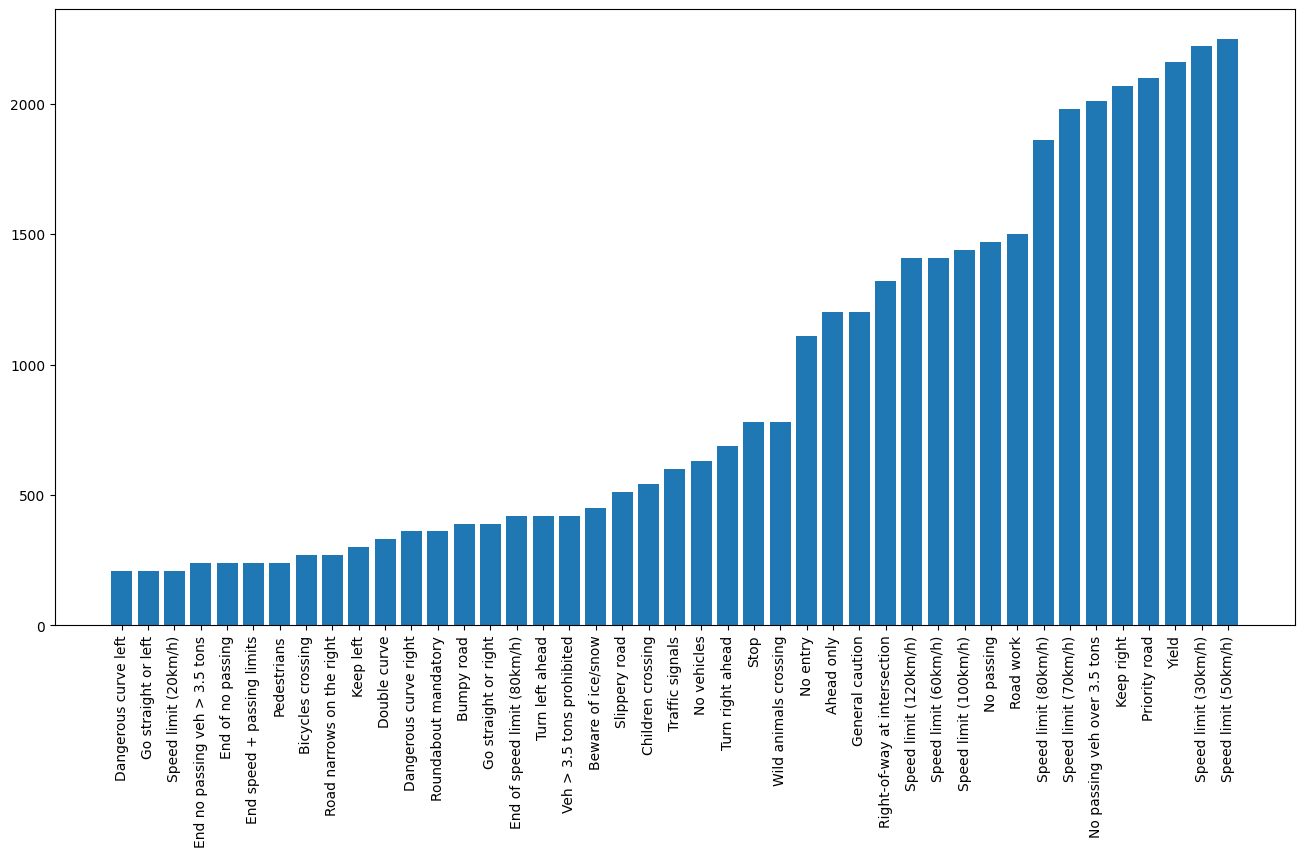

In [14]:
folders = os.listdir(TRAIN_DIR)
train_num = []
class_num = []

for folder in folders:
    train_files = os.listdir(os.path.join(TRAIN_DIR, folder))
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in  tuples]

# Plotting number of images in each class
plt.figure(figsize=(16, 8))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

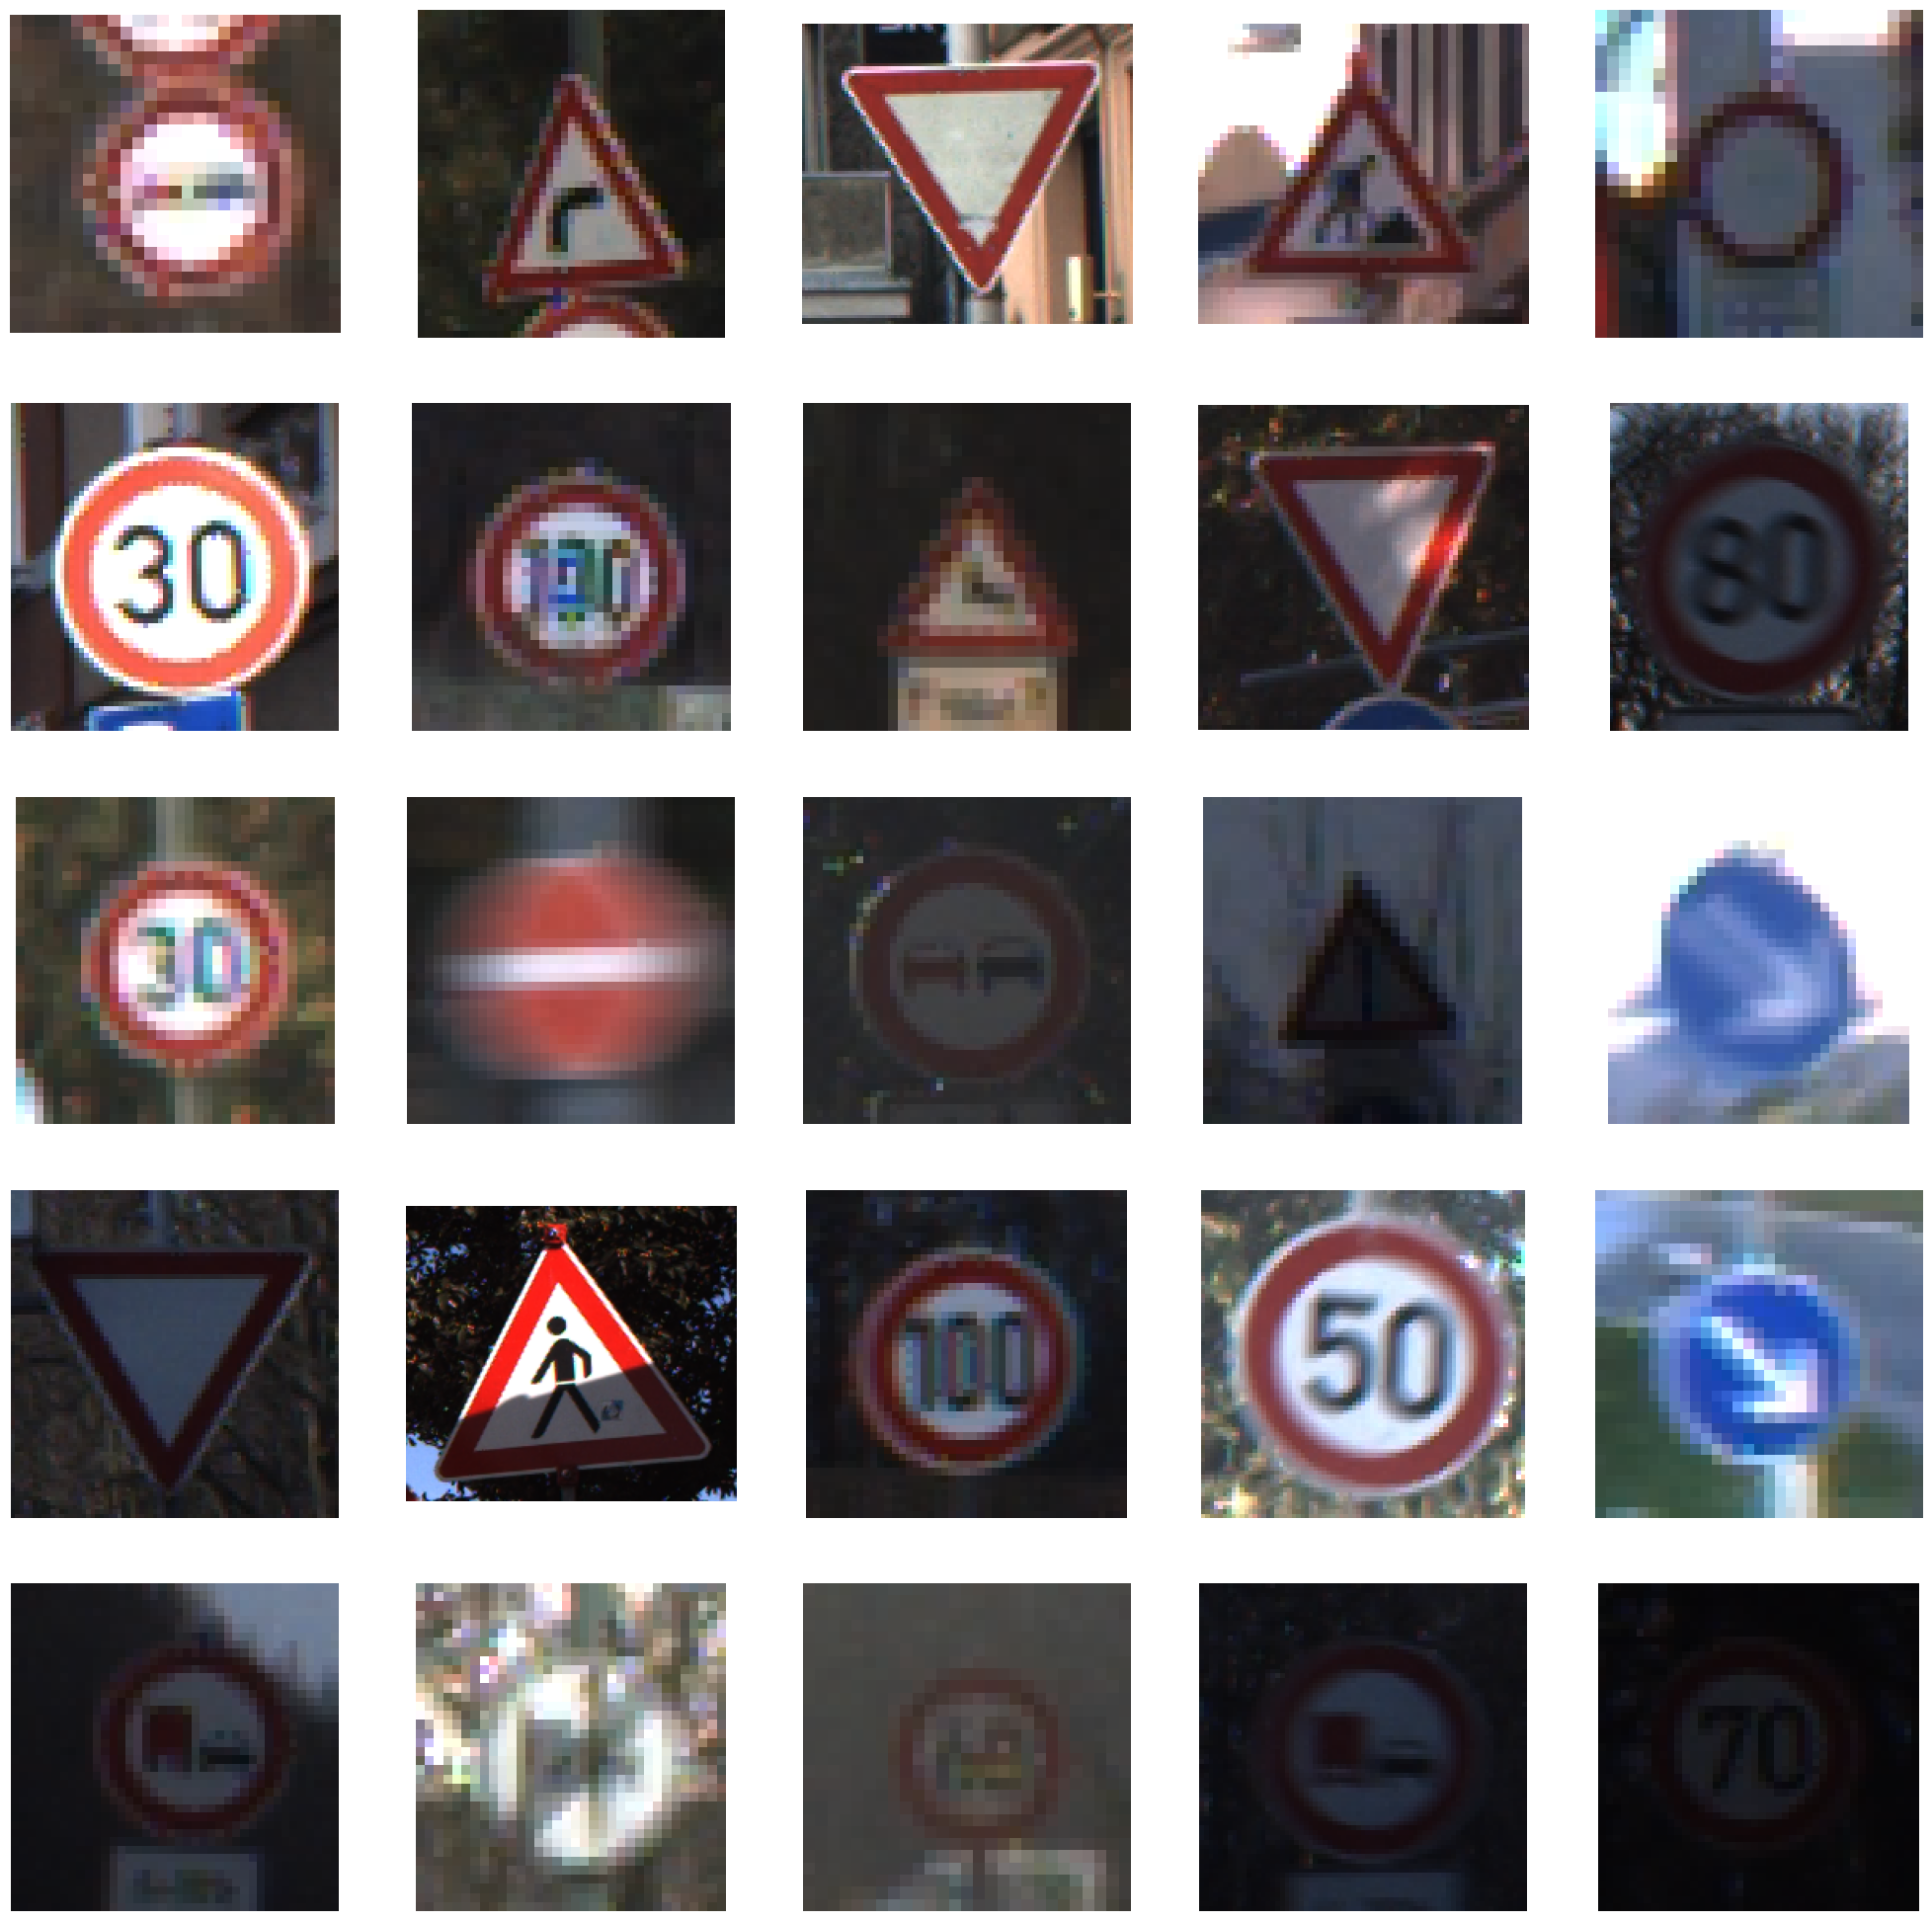

In [ ]:
test = pd.read_csv(os.path.join(DATA_DIR, "Test.csv"))
imgs = test["Path"].values
plt.figure(figsize=(25, 25))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_img_path = os.path.join(DATA_DIR, random.choice(imgs))
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    # plt.grid(b=None)
    plt.axis("off")

## Collecting the Training Data

In [16]:
%%time
image_data = []
image_labels = []

for i in range(43):
    path = os.path.join(TRAIN_DIR, str(i))
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(os.path.join(path, img))
            image_fromarray = Image.fromarray(image, "RGB")
            resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resized_image))
            image_labels.append(i)
        except:
            print(f"Error in {img}")

# Changing lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"Image Data -> {image_data.shape}")
print(f"Image Labels -> {image_labels.shape}")

Image Data -> (39209, 30, 30, 3)
Image Labels -> (39209,)
CPU times: total: 13.5 s
Wall time: 4min 57s


## Splitting the data into train and validation sets

In [ ]:
# Shuffling the data
shuffled_indices = np.arange(image_data.shape[0])
np.random.shuffle(shuffled_indices)
print(shuffled_indices)
image_data = image_data[shuffled_indices]
image_labels = image_labels[shuffled_indices]

# Now let's split the data
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255.
X_valid = X_valid/255.

print("X_train ->", X_train.shape)
print("X_valid ->", X_valid.shape)
print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

[16673 24911 15073 ... 34639  2927 17166]
X_train -> (27446, 30, 30, 3)
X_valid -> (11763, 30, 30, 3)
y_train -> (27446,)
y_valid -> (11763,)


## One Hot encoding the labels

In [18]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

y_train -> (27446, 43)
y_valid -> (11763, 43)


# Model

## Building the Model

In [19]:
model = keras.models.Sequential([
    Input((IMG_HEIGHT, IMG_WIDTH, channels)),
    Conv2D(16, (5, 5)),
    Conv2D(32, (5, 5)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3)),
    Conv2D(128, (3, 3)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,195 (770.29 KB)

 Trainable params: 195,851 (765.04 KB)

 Non-trainable params: 1,344 (5.25 KB)

In [20]:
lr = 0.001
epochs = 25

opt = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.08)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [21]:
augmentor = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [22]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(augmentor.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2625 - loss: 3.1624

858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - accuracy: 0.4028 - loss: 2.5114 - val_accuracy: 0.7281 - val_loss: 1.4750 - learning_rate: 0.0010
Epoch 2/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6658 - loss: 1.6315

858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.6989 - loss: 1.5436 - val_accuracy: 0.8811 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 3/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7626 - loss: 1.3737

858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.7808 - loss: 1.3264 - val_accuracy: 0.9454 - val_loss: 0.9048 - learning_rate: 0.0010
Epoch 4/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8158 - loss: 1.2291

858/858 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.8284 - loss: 1.1974 - val_accuracy: 0.9668 - val_loss: 0.8848 - learning_rate: 0.0010
Epoch 5/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8491 - loss: 1.1470

858/858 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.8550 - loss: 1.1281 - val_accuracy: 0.9721 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 6/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8740 - loss: 1.0739

858/858 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.8791 - loss: 1.0584 - val_accuracy: 0.9796 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 7/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 65s 76ms/step - accuracy: 0.8922 - loss: 1.0186 - val_accuracy: 0.9781 - val_loss: 0.7657 - learning_rate: 0.0010
Epoch 8/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9057 - loss: 0.9765

858/858 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - accuracy: 0.9089 - loss: 0.9700 - val_accuracy: 0.9857 - val_loss: 0.7557 - learning_rate: 0.0010
Epoch 9/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9147 - loss: 0.9484

858/858 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.9173 - loss: 0.9441 - val_accuracy: 0.9905 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 10/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.9262 - loss: 0.9195 - val_accuracy: 0.9872 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 11/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9295 - loss: 0.9009

858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.9311 - loss: 0.8973 - val_accuracy: 0.9923 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 12/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9384 - loss: 0.8826

858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 63ms/step - accuracy: 0.9366 - loss: 0.8808 - val_accuracy: 0.9927 - val_loss: 0.7275 - learning_rate: 0.0010
Epoch 13/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9408 - loss: 0.8673 - val_accuracy: 0.9917 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 14/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.9428 - loss: 0.8583 - val_accuracy: 0.9920 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 15/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9461 - loss: 0.8444

858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9473 - loss: 0.8442 - val_accuracy: 0.9944 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 16/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9520 - loss: 0.8333

858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9520 - loss: 0.8328 - val_accuracy: 0.9959 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 17/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9491 - loss: 0.8345

858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9529 - loss: 0.8264 - val_accuracy: 0.9969 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 18/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.9521 - loss: 0.8235 - val_accuracy: 0.9929 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 19/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.9581 - loss: 0.8129 - val_accuracy: 0.9969 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 20/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9651 - loss: 0.7883

858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.9660 - loss: 0.7848 - val_accuracy: 0.9974 - val_loss: 0.6891 - learning_rate: 5.0000e-04
Epoch 21/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9697 - loss: 0.7738

858/858 ━━━━━━━━━━━━━━━━━━━━ 78s 61ms/step - accuracy: 0.9694 - loss: 0.7720 - val_accuracy: 0.9977 - val_loss: 0.6673 - learning_rate: 5.0000e-04
Epoch 22/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9693 - loss: 0.7690

858/858 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - accuracy: 0.9684 - loss: 0.7697 - val_accuracy: 0.9979 - val_loss: 0.6783 - learning_rate: 5.0000e-04
Epoch 23/25
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9703 - loss: 0.7682

858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.9694 - loss: 0.7683 - val_accuracy: 0.9980 - val_loss: 0.6780 - learning_rate: 5.0000e-04
Epoch 24/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.9715 - loss: 0.7641 - val_accuracy: 0.9978 - val_loss: 0.6652 - learning_rate: 5.0000e-04
Epoch 25/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.9725 - loss: 0.7602 - val_accuracy: 0.9974 - val_loss: 0.6602 - learning_rate: 5.0000e-04
CPU times: total: 41min 4s
Wall time: 24min 16s


# Visualizing results

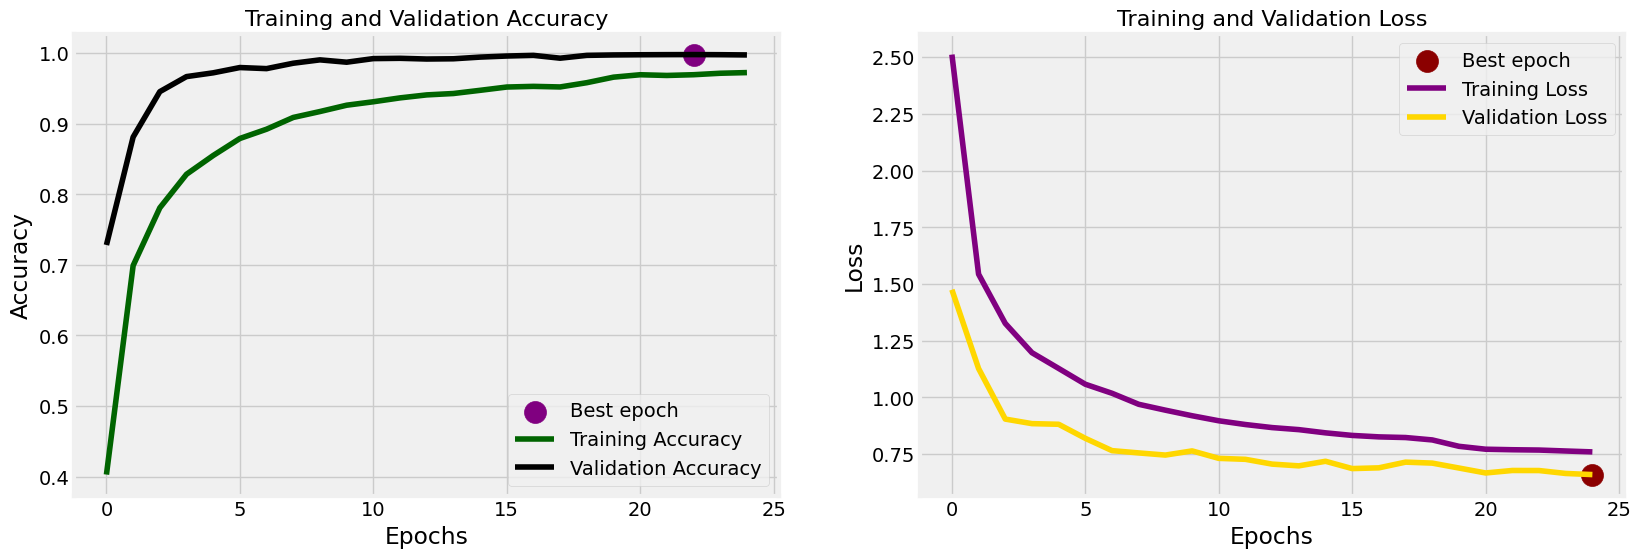

In [23]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

min_loss = np.argmin(val_loss)
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc)
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

plt.figure(figsize=(20,6))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.scatter(max_acc, val_max, s=250, c="purple", label="Best epoch")
plt.plot(epochs_, train_acc, 'darkgreen', label="Training Accuracy")
plt.plot(epochs_, val_acc, 'black', label="Validation Accuracy")
plt.title("Training and Validation Accuracy", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(min_loss, val_lowest, s=250, c="darkred", label="Best epoch")
plt.plot(epochs_, train_loss, 'purple', label="Training Loss")
plt.plot(epochs_, val_loss, 'gold', label="Validation Loss")
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Collecting Test Data and Evaluating the Model

In [24]:
test = pd.read_csv(os.path.join(DATA_DIR, 'Test.csv'))

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(os.path.join(DATA_DIR, img))
        image_fromarray = Image.fromarray(image, 'RGB')
        resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resized_image))
    except:
        print("Error in " + img)
        
X_test = np.array(data)
X_test = X_test/255.
labels = np.array(labels)
y_test = to_categorical(labels, 43)

In [25]:
model.evaluate(X_test, y_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9751 - loss: 0.7160


[0.7160474061965942, 0.9750593900680542]

### Visualizing the Confusion Matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


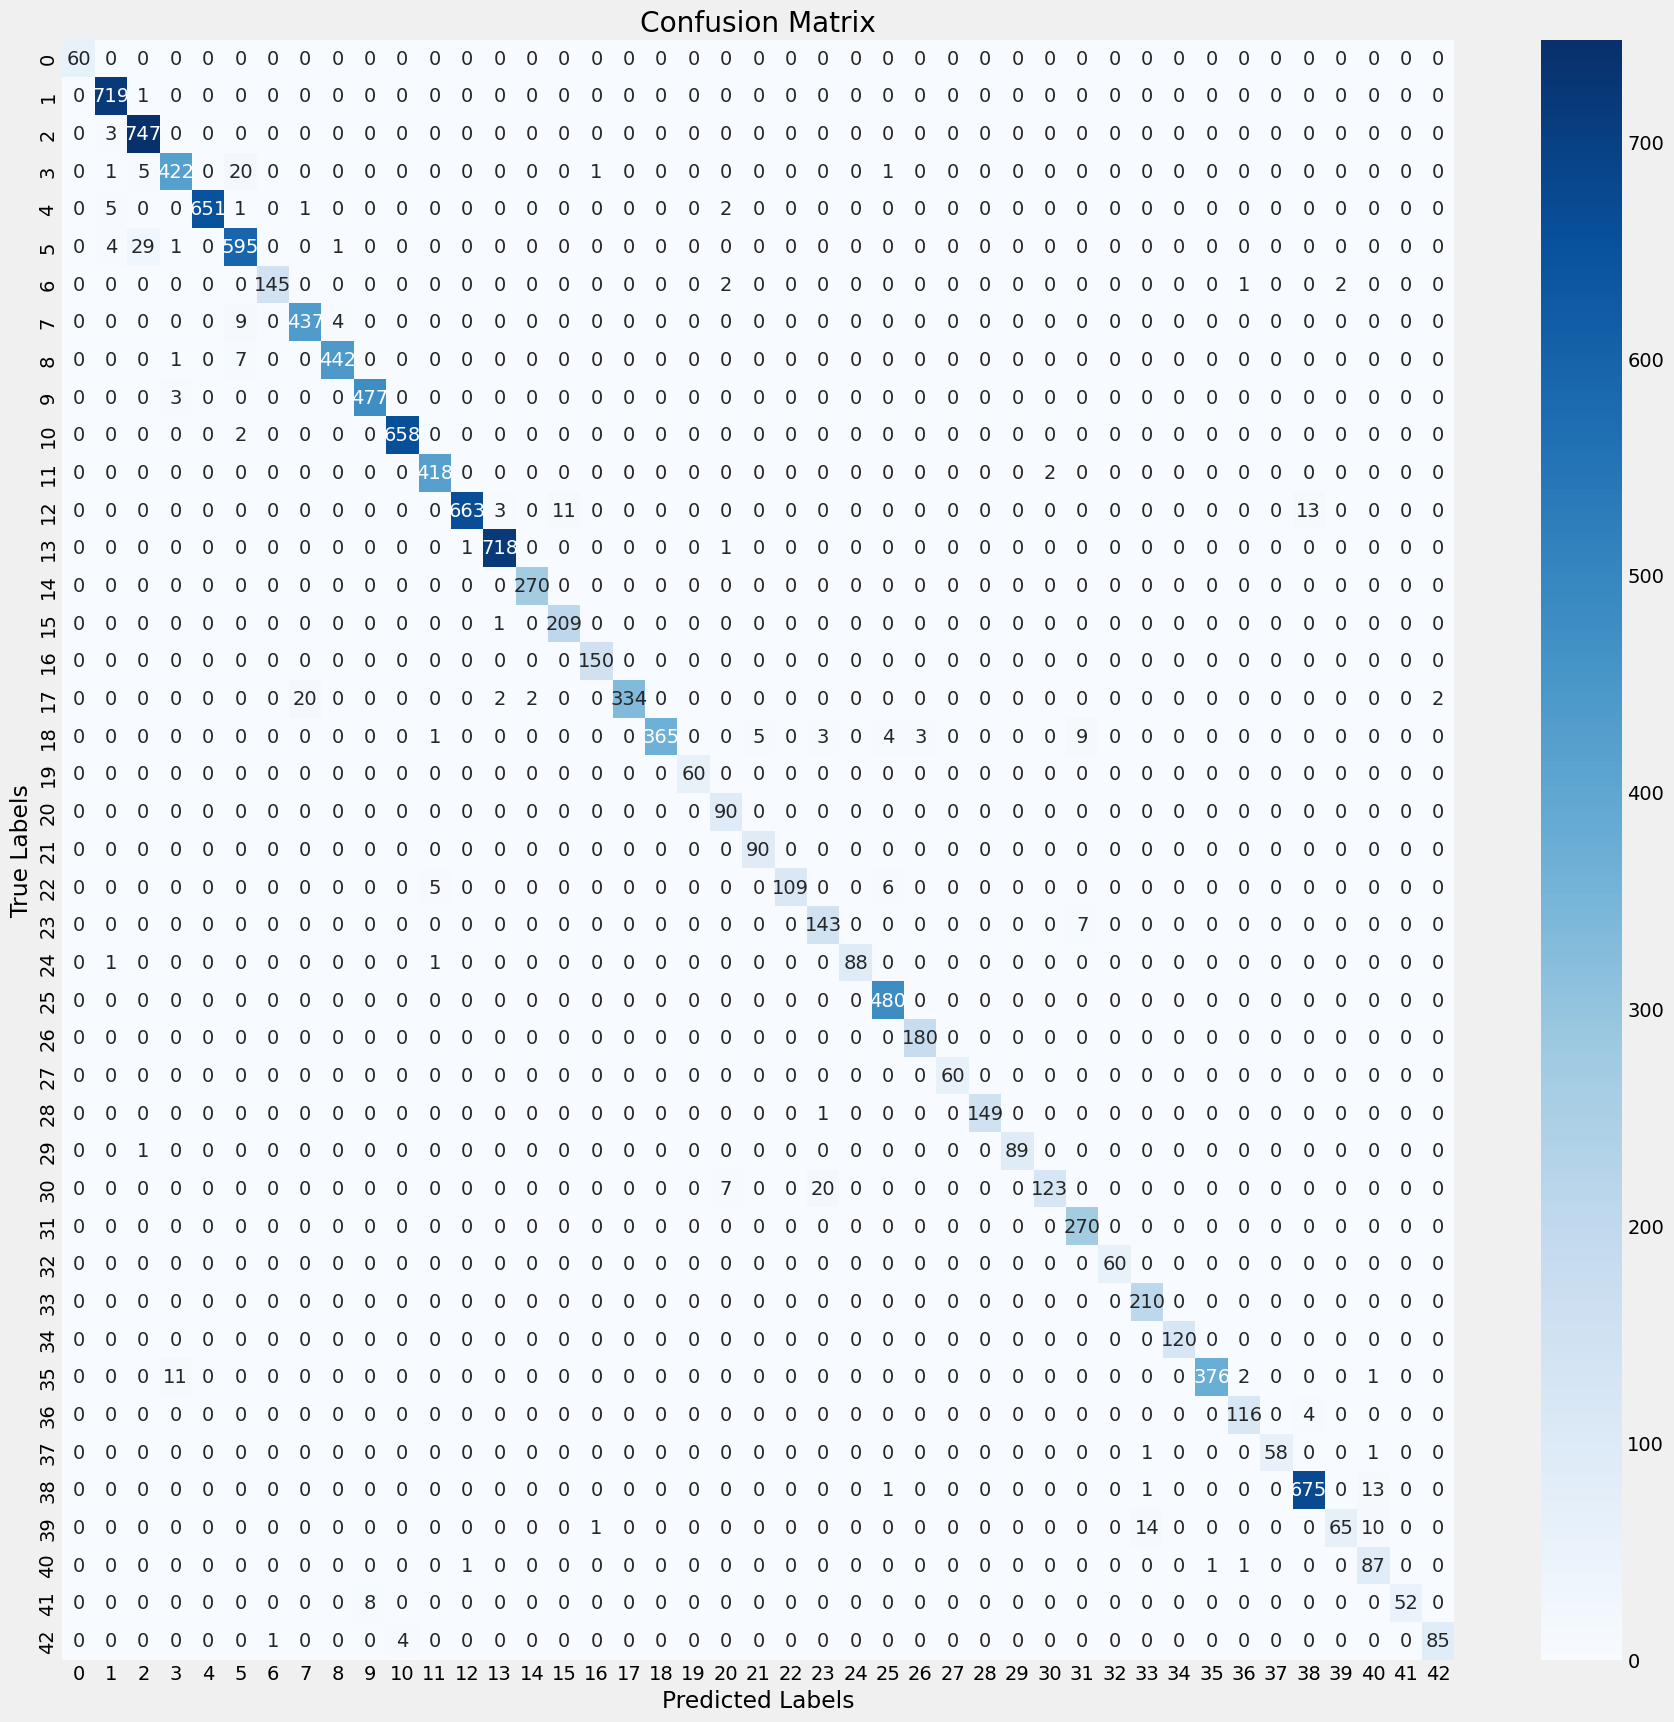

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)

cf = confusion_matrix(labels, pred_labels)

df_cm = pd.DataFrame(cf, index=classes, columns=classes)

plt.figure(figsize=(20,20))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Classification Report

In [27]:
print(classification_report(labels, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99       720
           2       0.95      1.00      0.97       750
           3       0.96      0.94      0.95       450
           4       1.00      0.99      0.99       660
           5       0.94      0.94      0.94       630
           6       0.99      0.97      0.98       150
           7       0.95      0.97      0.96       450
           8       0.99      0.98      0.99       450
           9       0.98      0.99      0.99       480
          10       0.99      1.00      1.00       660
          11       0.98      1.00      0.99       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.99      1.00      0.99       150
          17       1.00    

# Now let's save our model

In [28]:
model.save("traffic_sign_model.h5")

In [ ]:
'''
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")
print("Model loaded.")
'''


Model loaded.


In [1]:
from tensorflow.keras.models import load_model
model = load_model("traffic_sign_model.h5")
print("Model loaded.")


Model loaded.


In [7]:
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model


THRESHOLD = 0.60  
BOX_SIZE = 300         
IMG_SIZE = 30          


try:
    model = load_model("traffic_sign_model.h5")
    print("Model loaded successfully.")
except:
    print("Error: Could not load 'best_model.h5'. Make sure the file exists.")
    exit()


buffer_size = 10
pred_buffer = deque(maxlen=buffer_size)


cap = cv2.VideoCapture(0)


classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

while True:
    ret, frame = cap.read()
    if not ret:
        break



   
    h, w, _ = frame.shape
    x1 = (w - BOX_SIZE) // 2
    y1 = (h - BOX_SIZE) // 2
    x2 = x1 + BOX_SIZE
    y2 = y1 + BOX_SIZE
    
   
    roi = frame[y1:y2, x1:x2]

    if roi.size != 0:
        
        img = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)

        
        preds = model.predict(img, verbose=0)[0]
        class_id = np.argmax(preds)
        confidence = preds[class_id]

        
        box_color = (0, 0, 255) 
        display_text = "Scanning..."

        if confidence > THRESHOLD:
            
            pred_buffer.append(class_id)
            
            if len(pred_buffer) > 0:
             
                stabilized_id = max(set(pred_buffer), key=pred_buffer.count)
                
                label = classes[stabilized_id]
                percentage = confidence * 100
                
                display_text = f"{label} ({percentage:.1f}%)"
                box_color = (0, 255, 0) 
        else:
           
            if len(pred_buffer) > 0: pred_buffer.popleft() 
            display_text = "Unknown / Low Confidence"


        cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
q
 
        (text_w, text_h), _ = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(frame, (x1, y1 - 30), (x1 + text_w, y1), box_color, -1)
 
        text_color = (0, 0, 0) if confidence > THRESHOLD else (255, 255, 255)
        cv2.putText(frame, display_text, (x1, y1 - 7), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)


    cv2.imshow("Traffic Sign Detection System", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Model loaded successfully.


In [ ]:
'''
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# ----------- إعدادات التحكم -----------
THRESHOLD = 0.80       # نسبة التأكد (80%) - لن يعرض أي شيء أقل منها
BOX_SIZE = 250         # حجم مربع التركيز (أصغر قليلاً لزيادة الدقة)
IMG_SIZE = 30          # نفس حجم التدريب في الملف

# ----------- تحميل الموديل -----------
try:
    model = load_model("best_model.h5")
    print("Model loaded successfully.")
except:
    print("Error: Could not load 'best_model.h5'. Make sure the file exists.")
    exit()

# مخزن لتثبيت القراءة (يمنع اهتزاز الاسم)
pred_buffer = deque(maxlen=10)

cap = cv2.VideoCapture(0)

# أسماء العلامات كما في ملف التدريب
classes = { 
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 17:'No entry', 18:'General caution', 
    19:'Dangerous curve left', 20:'Dangerous curve right', 21:'Double curve', 
    22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 
    38:'Keep right', 39:'Keep left', 40:'Roundabout mandatory', 
    41:'End of no passing', 42:'End no passing veh > 3.5 tons' 
}

while True:
    ret, frame = cap.read()
    if not ret: break

    frame = cv2.flip(frame, 1) # مرآة

    # 1. تحديد مربع التركيز (ROI)
    h, w, _ = frame.shape
    x1, y1 = (w - BOX_SIZE) // 2, (h - BOX_SIZE) // 2
    x2, y2 = x1 + BOX_SIZE, y1 + BOX_SIZE
    roi = frame[y1:y2, x1:x2]

    # المتغيرات الافتراضية للعرض
    display_text = ""     # لا تعرض نص إذا لم يتم الكشف
    box_color = (0, 0, 255) # أحمر (وضع الاستعداد)

    if roi.size != 0:
        # 2. المعالجة (Preprocessing)
        # ملاحظة هامة: قمت بإزالة تحويل BGR2RGB ليطابق طريقة التدريب الخاصة بك
        img = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
        
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # <--- تم إيقاف هذا السطر عمداً
        
        img = img.astype('float32') / 255.0
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)

        # 3. التوقع
        preds = model.predict(img, verbose=0)[0]
        class_id = np.argmax(preds)
        confidence = preds[class_id]

        # طباعة للتجربة في الـ Console
        # print(f"Class: {class_id} - {classes[class_id]} ({confidence:.2f})")

        # 4. شرط الثقة (Threshold)
        if confidence >= THRESHOLD:
            pred_buffer.append(class_id)
            
            # نستخدم القيم الأكثر تكراراً لضمان الثبات
            if len(pred_buffer) > 0:
                stabilized_id = max(set(pred_buffer), key=pred_buffer.count)
                
                display_text = f"{classes[stabilized_id]} ({int(confidence*100)}%)"
                box_color = (0, 255, 0) # أخضر (تم التعرف)
        else:
            # تفريغ الذاكرة تدريجياً إذا لم نعد نرى علامة واضحة
            if len(pred_buffer) > 0: pred_buffer.popleft()

    # 5. الرسم
    # رسم المربع
    cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 3)

    # عرض النص فقط إذا تم التعرف على علامة
    if display_text:
        # خلفية للنص
        (text_w, text_h), _ = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        cv2.rectangle(frame, (x1, y1 - 35), (x1 + text_w, y1), box_color, -1)
        # النص
        cv2.putText(frame, display_text, (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    cv2.imshow("Traffic Sign Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

cap.release()
cv2.destroyAllWindows()
'''

Model loaded successfully.
